In [24]:
#We load in the specific data needed
import polars as pl
import numpy as np
import os
from pathlib import Path
import pandas as pd
from datetime import date
import datetime
import hvplot.polars
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.interpolate import bisplrep, bisplev
from datetime import timedelta
from patsy import dmatrix
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score

data = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/updated_standardization/data_set_train_tech_nonscaled.parquet')
datat = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/updated_standardization/data_set_test_tech_nonscaled.parquet')
firm_data = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Firm_variables/daily_firm_data_median_new.parquet')

columns_todrop =firm_data.columns[2:]

columnstodrop_ex = ['const',
 'moneyness',
 'prev2_day_iv',
 'prev_day_iv',
 'trading_days_till_exp',
 '5_day_rolling_return_stock',
 'PRC',
 'PRC_actual',
 'RET',
 'RETX',
 'cumulative_return',
 'daily_return_indicator_stock',
 'vol_stock',
 '10Y_RIR',
 '1Y_bond',
 '2Y_bond',
 'CLOSE_vix',
 'FF_rate',
 'OPEN_vix',
 'gold_price',
 'reces_indi']

datat.drop(columns=columns_todrop, inplace=True, errors='ignore')
data.drop(columns=columns_todrop, inplace=True, errors='ignore')

datat.drop(columns=[ 'T'], inplace=True)
data.drop(columns=[ 'T'], inplace=True)

test_data = datat[datat['date'] >= '2021-01-01']
total_train = data[data['date'] < '2021-01-01']

In [25]:
# Assuming total_train and test_data are your DataFrames

# Get the columns of test_data
total_train_columns = total_train.columns

# Filter total_train to keep only the columns that are present in test_data
test_data_filtered = test_data[total_train_columns]

# Display the first 5 rows of the filtered total_train to verify the change
test_data_filtered.head(5)

test_data = test_data_filtered 

In [26]:
puts_data_all = total_train[total_train['cp_flag'] == 'P']

puts_data_test = test_data[test_data['cp_flag'] == 'P']

calls_data_all = total_train[total_train['cp_flag'] == 'C']

calls_data_test = test_data[test_data['cp_flag'] == 'C']

total_data = pd.concat([total_train, test_data], axis=0)

total_data

,cp_flag,Ticker,date,trading_days_till_exp,moneyness,impl_volatility,prev_day_iv,prev2_day_iv,BIDLO,ASKHI,...,gold_price,reces_indi,10Y_RIR,1Y_bond,2Y_bond,OPEN_vix,HIGH_vix,LOW_vix,CLOSE_vix,spread_vix
0,P,AAPL,2019-01-02,2,-1.860,0.558181,0.505761,0.000000,154.55000,158.52000,...,449.000000,0.130000,2.66,2.5342,2.5442,31.72,31.74,28.57,28.57,3.17
1,P,AAPL,2019-01-02,2,-1.682,0.541292,0.495051,0.000000,154.55000,158.52000,...,449.000000,0.130000,2.66,2.5342,2.5442,31.72,31.74,28.57,28.57,3.17
2,P,AAPL,2019-01-02,2,-1.505,0.525111,0.484170,0.000000,154.55000,158.52000,...,449.000000,0.130000,2.66,2.5342,2.5442,31.72,31.74,28.57,28.57,3.17
3,P,AAPL,2019-01-02,2,-1.330,0.507597,0.473299,0.000000,154.55000,158.52000,...,449.000000,0.130000,2.66,2.5342,2.5442,31.72,31.74,28.57,28.57,3.17
4,P,AAPL,2019-01-02,2,-0.895,0.468786,0.455607,0.000000,154.55000,158.52000,...,449.000000,0.130000,2.66,2.5342,2.5442,31.72,31.74,28.57,28.57,3.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71690,P,TSLA,2021-12-30,1,-0.027,0.484270,0.520039,0.592762,1078.42004,1118.99988,...,632.874194,-0.206774,1.55,0.4878,0.8182,14.36,14.60,12.56,12.85,2.04
71691,P,TSLA,2021-12-30,1,0.081,0.503165,0.520221,0.600908,1078.42004,1118.99988,...,632.874194,-0.206774,1.55,0.4878,0.8182,14.36,14.60,12.56,12.85,2.04
71692,P,TSLA,2021-12-30,1,0.190,0.536047,0.525230,0.609799,1078.42004,1118.99988,...,632.874194,-0.206774,1.55,0.4878,0.8182,14.36,14.60,12.56,12.85,2.04
71693,P,TSLA,2021-12-30,1,0.298,0.550971,0.529985,0.620276,1078.42004,1118.99988,...,632.874194,-0.206774,1.55,0.4878,0.8182,14.36,14.60,12.56,12.85,2.04


In [27]:
puts_data_test

,cp_flag,Ticker,date,trading_days_till_exp,moneyness,impl_volatility,prev_day_iv,prev2_day_iv,BIDLO,ASKHI,...,gold_price,reces_indi,10Y_RIR,1Y_bond,2Y_bond,OPEN_vix,HIGH_vix,LOW_vix,CLOSE_vix,spread_vix
36352,P,AAPL,2021-01-04,4,-1.977,0.622737,0.404451,0.452074,133.39999,135.99001,...,672.012903,3.036452,0.93,0.1074,0.1400,21.29,22.49,20.57,21.20,1.92
36353,P,AAPL,2021-01-04,4,-1.835,0.598160,0.383928,0.418943,133.39999,135.99001,...,672.012903,3.036452,0.93,0.1074,0.1400,21.29,22.49,20.57,21.20,1.92
36354,P,AAPL,2021-01-04,4,-1.694,0.570362,0.374351,0.403192,133.39999,135.99001,...,672.012903,3.036452,0.93,0.1074,0.1400,21.29,22.49,20.57,21.20,1.92
36355,P,AAPL,2021-01-04,4,-1.554,0.549241,0.365382,0.388048,133.39999,135.99001,...,672.012903,3.036452,0.93,0.1074,0.1400,21.29,22.49,20.57,21.20,1.92
36356,P,AAPL,2021-01-04,4,-1.415,0.526871,0.349066,0.360382,133.39999,135.99001,...,672.012903,3.036452,0.93,0.1074,0.1400,21.29,22.49,20.57,21.20,1.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71690,P,TSLA,2021-12-30,1,-0.027,0.484270,0.520039,0.592762,1078.42004,1118.99988,...,632.874194,-0.206774,1.55,0.4878,0.8182,14.36,14.60,12.56,12.85,2.04
71691,P,TSLA,2021-12-30,1,0.081,0.503165,0.520221,0.600908,1078.42004,1118.99988,...,632.874194,-0.206774,1.55,0.4878,0.8182,14.36,14.60,12.56,12.85,2.04
71692,P,TSLA,2021-12-30,1,0.190,0.536047,0.525230,0.609799,1078.42004,1118.99988,...,632.874194,-0.206774,1.55,0.4878,0.8182,14.36,14.60,12.56,12.85,2.04
71693,P,TSLA,2021-12-30,1,0.298,0.550971,0.529985,0.620276,1078.42004,1118.99988,...,632.874194,-0.206774,1.55,0.4878,0.8182,14.36,14.60,12.56,12.85,2.04


# Puts and Call data insample / outsample

Puts (cp_flag = 'P') Model Summary:
                            OLS Regression Results                            
Dep. Variable:        impl_volatility   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     9199.
Date:                Mon, 02 Sep 2024   Prob (F-statistic):               0.00
Time:                        17:24:15   Log-Likelihood:                 17491.
No. Observations:               72964   AIC:                        -3.493e+04
Df Residuals:                   72937   BIC:                        -3.468e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

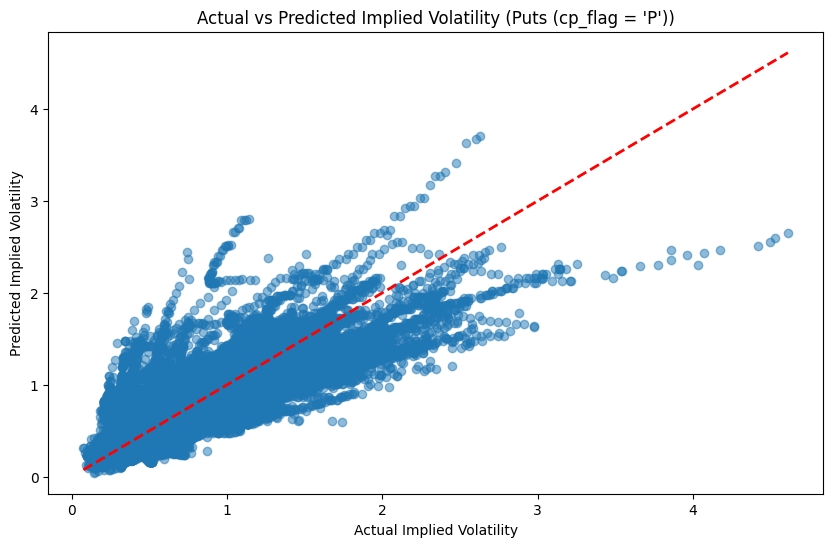

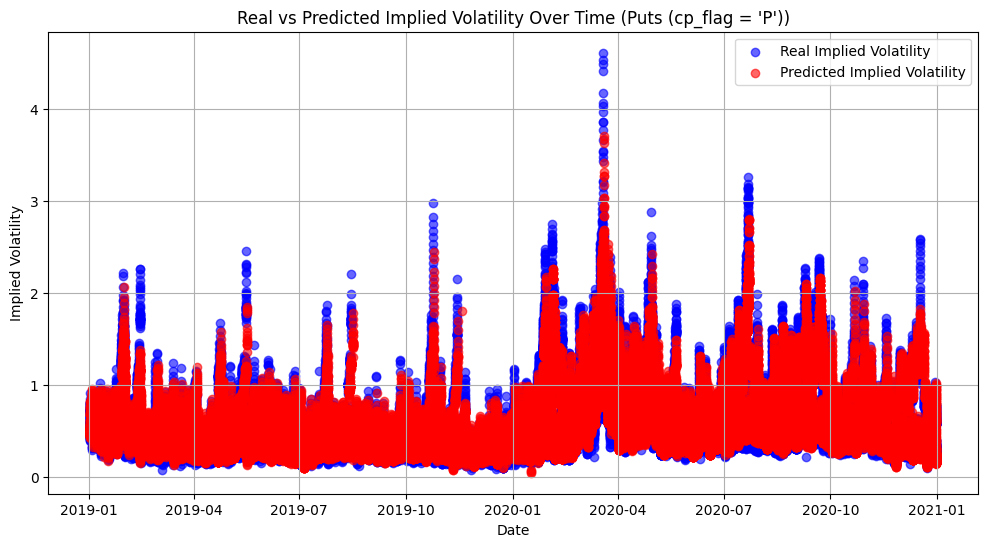

Puts (cp_flag = 'P') Out-of-sample RMSE: 0.1576709925578779
Puts (cp_flag = 'P') Out-of-sample R²: 0.5916239823868238


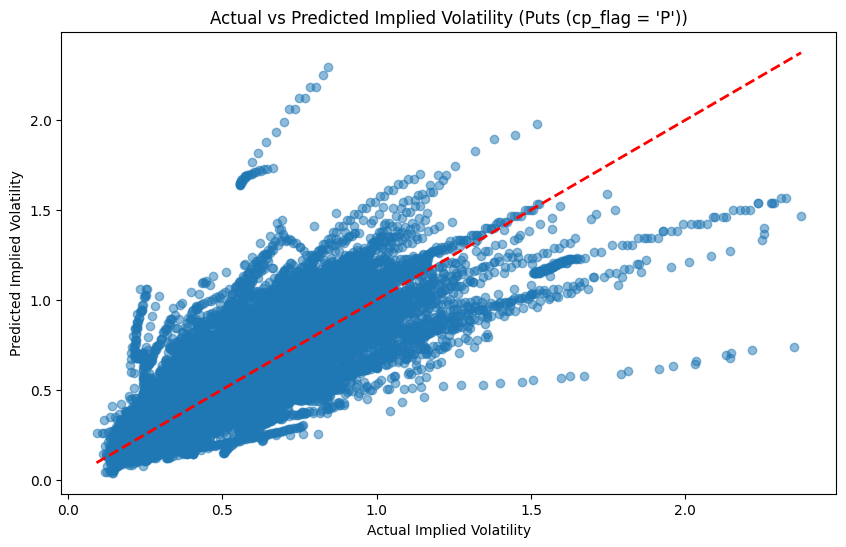

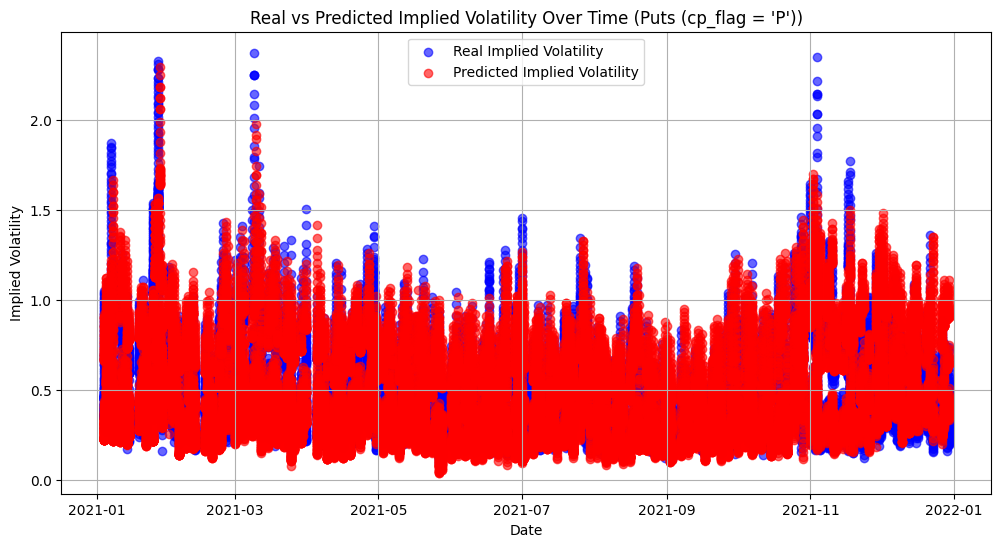

Calls (cp_flag = 'C') Model Summary:
                            OLS Regression Results                            
Dep. Variable:        impl_volatility   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     7417.
Date:                Mon, 02 Sep 2024   Prob (F-statistic):               0.00
Time:                        17:24:18   Log-Likelihood:                 16826.
No. Observations:               72347   AIC:                        -3.360e+04
Df Residuals:                   72320   BIC:                        -3.335e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

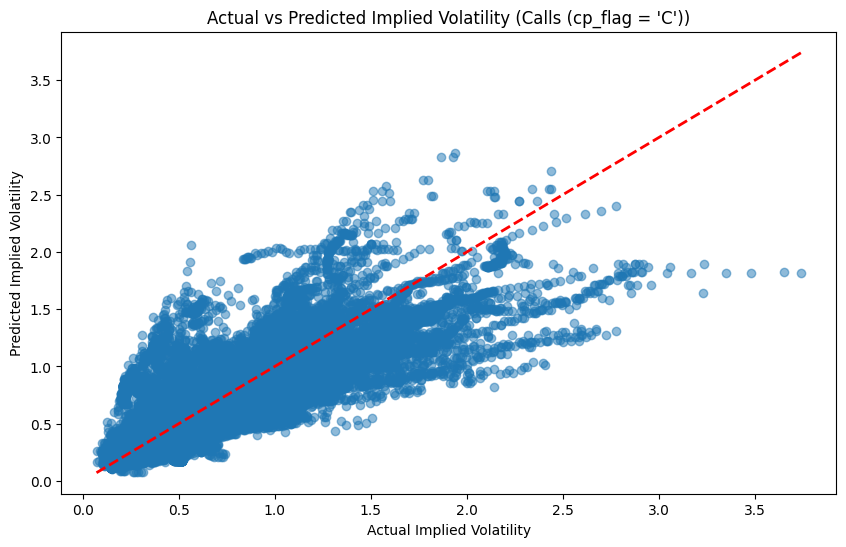

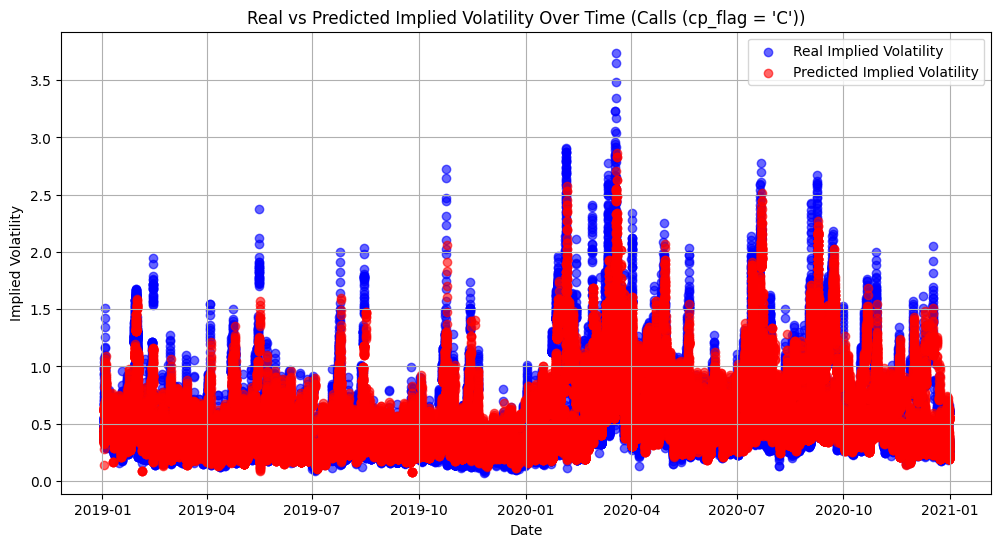

Calls (cp_flag = 'C') Out-of-sample RMSE: 0.1566075392715709
Calls (cp_flag = 'C') Out-of-sample R²: 0.5690461302991918


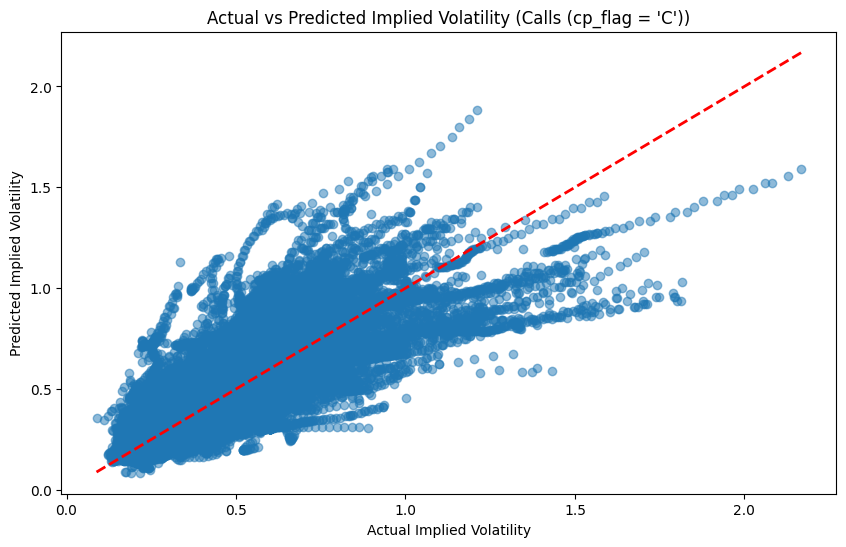

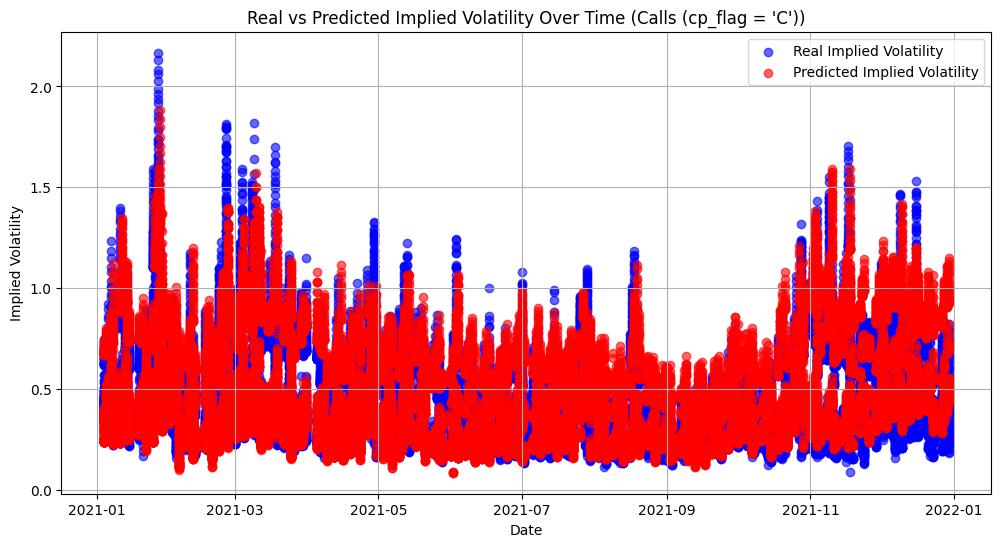

In [28]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

def run_ols(data, title):
    """Runs OLS regression, calculates RMSE and R², and plots results."""
    # Prepare the data
    y = data['impl_volatility']
    X = data.drop(columns=['date', 'Ticker', 'cp_flag', 'impl_volatility'])
    X = sm.add_constant(X)

    # Fit the OLS model
    model = sm.OLS(y, X).fit()
    print(f"{title} Model Summary:")
    print(model.summary())

    # Predict on the in-sample data
    y_pred = model.predict(X)

    # Calculate RMSE for in-sample data
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    print(f'{title} In-sample RMSE: {rmse}')

    # Calculate R² for in-sample data
    r2 = r2_score(y, y_pred)
    print(f'{title} In-sample R²: {r2}')

    # Plot y against y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y, y_pred, alpha=0.5)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
    plt.xlabel('Actual Implied Volatility')
    plt.ylabel('Predicted Implied Volatility')
    plt.title(f'Actual vs Predicted Implied Volatility ({title})')
    plt.show()

    # Plot Real vs Predicted Implied Volatility over time
    plt.figure(figsize=(12, 6))
    plt.scatter(data['date'], y, label='Real Implied Volatility', color='blue', alpha=0.6)
    plt.scatter(data['date'], y_pred, label='Predicted Implied Volatility', color='red', alpha=0.6)
    plt.xlabel('Date')
    plt.ylabel('Implied Volatility')
    plt.title(f'Real vs Predicted Implied Volatility Over Time ({title})')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model

def evaluate_on_test_set(model, test_data, title):
    """Evaluate the model on test data, calculate RMSE and R², and plot results."""
    # Prepare the test data using only the features from the in-sample model
    selected_features = model.params.index.drop('const')  # Use the same features selected in the training model
    X_test = test_data[selected_features]
    X_test = sm.add_constant(X_test)

    # Predict on the test set
    y_test = test_data['impl_volatility']
    y_pred = model.predict(X_test)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'{title} Out-of-sample RMSE: {rmse}')

    # Calculate R²
    r2 = r2_score(y_test, y_pred)
    print(f'{title} Out-of-sample R²: {r2}')

    # Plot y_test against y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Implied Volatility')
    plt.ylabel('Predicted Implied Volatility')
    plt.title(f'Actual vs Predicted Implied Volatility ({title})')
    plt.show()

    # Plot Real vs Predicted Implied Volatility over time
    plt.figure(figsize=(12, 6))
    plt.scatter(test_data['date'], y_test, label='Real Implied Volatility', color='blue', alpha=0.6)
    plt.scatter(test_data['date'], y_pred, label='Predicted Implied Volatility', color='red', alpha=0.6)
    plt.xlabel('Date')
    plt.ylabel('Implied Volatility')
    plt.title(f'Real vs Predicted Implied Volatility Over Time ({title})')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run OLS for puts data
ols_puts = run_ols(puts_data_all, "Puts (cp_flag = 'P')")

# Evaluate the puts model on the test set
evaluate_on_test_set(ols_puts, puts_data_test, "Puts (cp_flag = 'P')")

# Run OLS for calls data
ols_calls = run_ols(calls_data_all, "Calls (cp_flag = 'C')")

# Evaluate the calls model on the test set
evaluate_on_test_set(ols_calls, calls_data_test, "Calls (cp_flag = 'C')")


# Now for the ADHOC BS

In [33]:
# Select the relevant columns for ADHBS model
selected_columns = ['Ticker', 'date', 'cp_flag', 'impl_volatility', 'moneyness', 'trading_days_till_exp']
total_train_new = total_data[selected_columns]

total_train_new['moneyness_squared'] = total_train_new['moneyness'] ** 2
total_train_new['tau_squared'] = total_train_new['trading_days_till_exp'] ** 2
total_train_new['moneyness_tau'] = total_train_new['moneyness'] * total_train_new['trading_days_till_exp']

calls_data = total_train_new[total_train_new['cp_flag'] == 'C']
puts_data = total_train_new[total_train_new['cp_flag'] == 'P']

train_calls_data = calls_data[calls_data['date'] < '2021-01-01']
test_calls_data = calls_data[calls_data['date'] >= '2021-01-01']
train_puts_data = puts_data[puts_data['date'] < '2021-01-01']
test_puts_data = puts_data[puts_data['date'] >= '2021-01-01']

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_26444/3476977650.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_train_new['moneyness_squared'] = total_train_new['moneyness'] ** 2
/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_26444/3476977650.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_train_new['tau_squared'] = total_train_new['trading_days_till_exp'] ** 2
/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_26444/3476977650.py:7: SettingWithCopyWarning

In [37]:
train_puts_data

,Ticker,date,cp_flag,impl_volatility,moneyness,trading_days_till_exp,moneyness_squared,tau_squared,moneyness_tau
0,AAPL,2019-01-02,P,0.558181,-1.860,2,3.459600,4,-3.720
1,AAPL,2019-01-02,P,0.541292,-1.682,2,2.829124,4,-3.364
2,AAPL,2019-01-02,P,0.525111,-1.505,2,2.265025,4,-3.010
3,AAPL,2019-01-02,P,0.507597,-1.330,2,1.768900,4,-2.660
4,AAPL,2019-01-02,P,0.468786,-0.895,2,0.801025,4,-1.790
...,...,...,...,...,...,...,...,...,...
72959,TSLA,2020-12-31,P,0.573773,0.236,5,0.055696,25,1.180
72960,TSLA,2020-12-31,P,0.573565,0.274,5,0.075076,25,1.370
72961,TSLA,2020-12-31,P,0.572960,0.312,5,0.097344,25,1.560
72962,TSLA,2020-12-31,P,0.573072,0.388,5,0.150544,25,1.940


AHBS Model Summary for Puts (cp_flag = 'P'):
                            OLS Regression Results                            
Dep. Variable:        impl_volatility   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     689.5
Date:                Mon, 02 Sep 2024   Prob (F-statistic):               0.00
Time:                        17:29:47   Log-Likelihood:                -33860.
No. Observations:               72964   AIC:                         6.773e+04
Df Residuals:                   72958   BIC:                         6.779e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_26444/2542386628.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_puts_data['predicted_impl_volatility'] = adhbs_model_puts.predict(sm.add_constant(train_puts_data[['moneyness', 'moneyness_squared', 'trading_days_till_exp', 'tau_squared', 'moneyness_tau']]))


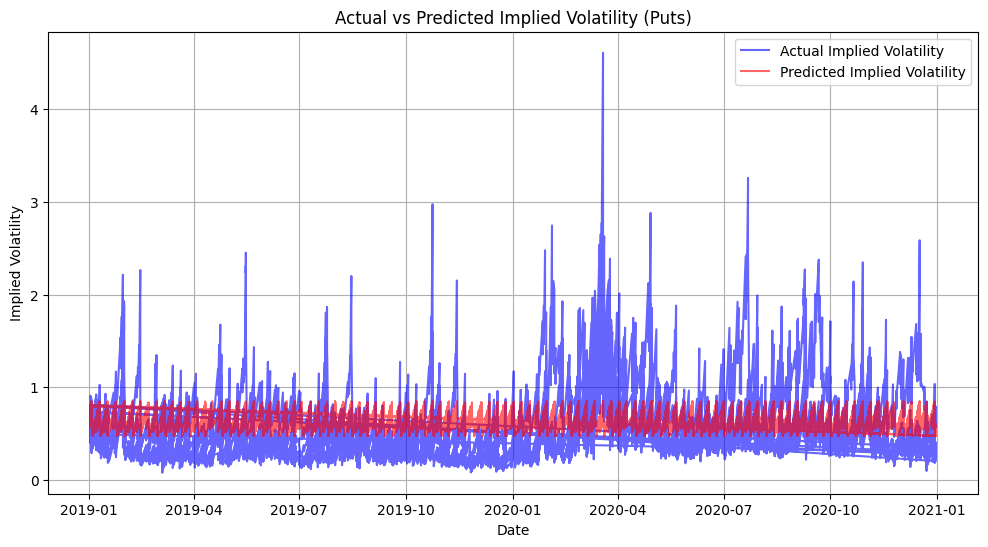

In [38]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Function to fit AHBS model
def adhbs_model(data):
    X = data[['moneyness', 'moneyness_squared', 'trading_days_till_exp', 'tau_squared', 'moneyness_tau']]
    X = sm.add_constant(X)
    y = data['impl_volatility']
    model = sm.OLS(y, X).fit()
    return model

# Fit the AHBS model for puts
adhbs_model_puts = adhbs_model(train_puts_data)
print("AHBS Model Summary for Puts (cp_flag = 'P'):")
print(adhbs_model_puts.summary())

# Generate predictions using the model
train_puts_data['predicted_impl_volatility'] = adhbs_model_puts.predict(sm.add_constant(train_puts_data[['moneyness', 'moneyness_squared', 'trading_days_till_exp', 'tau_squared', 'moneyness_tau']]))

# Plot actual vs predicted implied volatility
plt.figure(figsize=(12, 6))
plt.plot(train_puts_data['date'], train_puts_data['impl_volatility'], label='Actual Implied Volatility', color='blue', alpha=0.6)
plt.plot(train_puts_data['date'], train_puts_data['predicted_impl_volatility'], label='Predicted Implied Volatility', color='red', alpha=0.6)
plt.xlabel('Date')
plt.ylabel('Implied Volatility')
plt.title('Actual vs Predicted Implied Volatility (Puts)')
plt.legend()
plt.grid(True)
plt.show()


AHBS Model Summary for Puts (In-Sample, cp_flag = 'P'):
                            OLS Regression Results                            
Dep. Variable:        impl_volatility   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     689.5
Date:                Tue, 03 Sep 2024   Prob (F-statistic):               0.00
Time:                        02:44:44   Log-Likelihood:                -33860.
No. Observations:               72964   AIC:                         6.773e+04
Df Residuals:                   72958   BIC:                         6.779e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_26444/4258974343.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_puts_data['predicted_impl_volatility'] = adhbs_model_puts.predict(sm.add_constant(train_puts_data[['moneyness', 'moneyness_squared', 'trading_days_till_exp', 'tau_squared', 'moneyness_tau']]))
/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_26444/4258974343.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_puts_data['predicted_impl_volatility'] = adhbs_mod

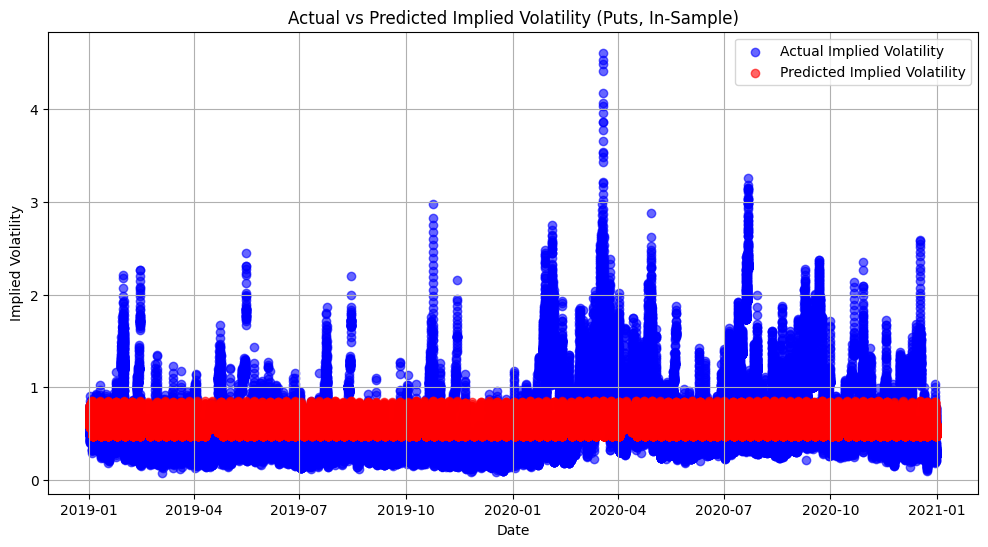

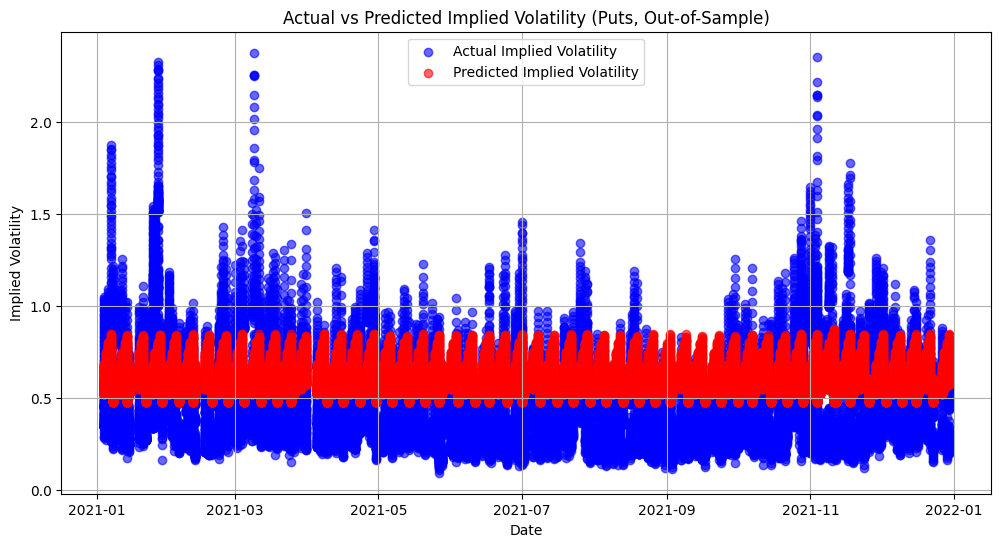

AHBS Model Summary for Calls (In-Sample, cp_flag = 'C'):
                            OLS Regression Results                            
Dep. Variable:        impl_volatility   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     504.6
Date:                Tue, 03 Sep 2024   Prob (F-statistic):               0.00
Time:                        02:44:46   Log-Likelihood:                -28932.
No. Observations:               72347   AIC:                         5.788e+04
Df Residuals:                   72341   BIC:                         5.793e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_26444/4258974343.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_calls_data['predicted_impl_volatility'] = adhbs_model_calls.predict(sm.add_constant(train_calls_data[['moneyness', 'moneyness_squared', 'trading_days_till_exp', 'tau_squared', 'moneyness_tau']]))
/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_26444/4258974343.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_calls_data['predicted_impl_volatility'] = adhbs

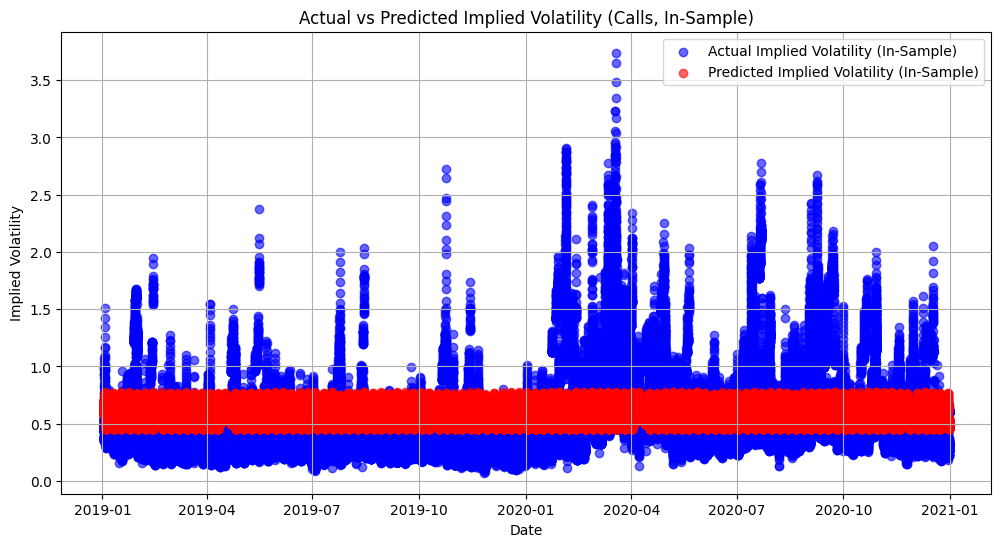

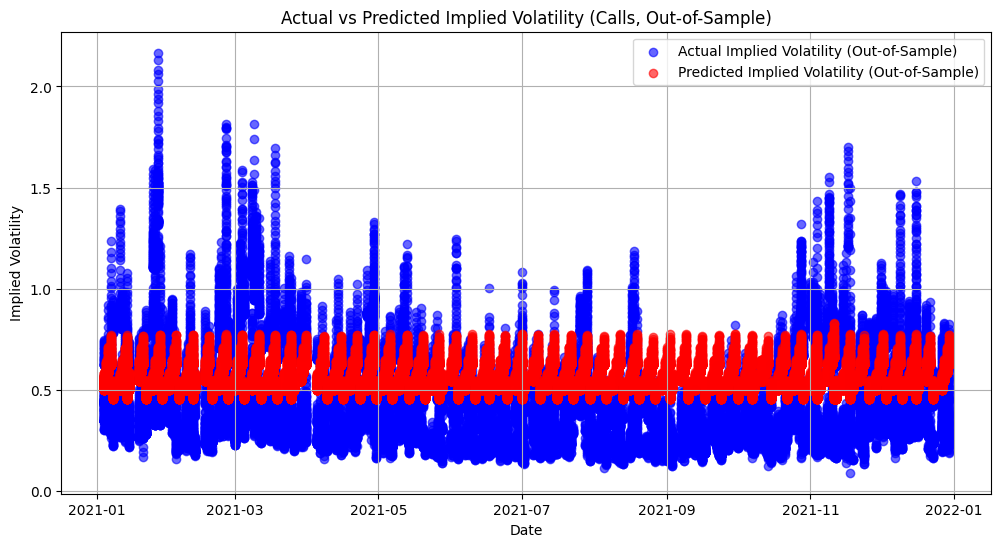

In [42]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Function to fit AHBS model
def adhbs_model(data):
    X = data[['moneyness', 'moneyness_squared', 'trading_days_till_exp', 'tau_squared', 'moneyness_tau']]
    X = sm.add_constant(X)
    y = data['impl_volatility']
    model = sm.OLS(y, X).fit()
    return model

# Fit the AHBS model for puts (In-Sample)
adhbs_model_puts = adhbs_model(train_puts_data)
print("AHBS Model Summary for Puts (In-Sample, cp_flag = 'P'):")
print(adhbs_model_puts.summary())

# Generate in-sample predictions for puts
train_puts_data['predicted_impl_volatility'] = adhbs_model_puts.predict(sm.add_constant(train_puts_data[['moneyness', 'moneyness_squared', 'trading_days_till_exp', 'tau_squared', 'moneyness_tau']]))

# Out-of-sample prediction for puts
test_puts_data['predicted_impl_volatility'] = adhbs_model_puts.predict(sm.add_constant(test_puts_data[['moneyness', 'moneyness_squared', 'trading_days_till_exp', 'tau_squared', 'moneyness_tau']]))

# Calculate Out-of-Sample R^2 and RMSE for puts
r2_puts = r2_score(test_puts_data['impl_volatility'], test_puts_data['predicted_impl_volatility'])
rmse_puts = np.sqrt(mean_squared_error(test_puts_data['impl_volatility'], test_puts_data['predicted_impl_volatility']))

print(f"Out-of-Sample R^2 for Puts: {r2_puts}")
print(f"Out-of-Sample RMSE for Puts: {rmse_puts}")

# Plot actual vs predicted implied volatility for puts (In-Sample)
plt.figure(figsize=(12, 6))
plt.scatter(train_puts_data['date'], train_puts_data['impl_volatility'], label='Actual Implied Volatility', color='blue', alpha=0.6)
plt.scatter(train_puts_data['date'], train_puts_data['predicted_impl_volatility'], label='Predicted Implied Volatility', color='red', alpha=0.6)
plt.xlabel('Date')
plt.ylabel('Implied Volatility')
plt.title('Actual vs Predicted Implied Volatility (Puts, In-Sample)')
plt.legend()
plt.grid(True)
plt.show()

# Plot actual vs predicted implied volatility for puts (Out-of-Sample)
plt.figure(figsize=(12, 6))
plt.scatter(test_puts_data['date'], test_puts_data['impl_volatility'], label='Actual Implied Volatility', color='blue', alpha=0.6)
plt.scatter(test_puts_data['date'], test_puts_data['predicted_impl_volatility'], label='Predicted Implied Volatility', color='red', alpha=0.6)
plt.xlabel('Date')
plt.ylabel('Implied Volatility')
plt.title('Actual vs Predicted Implied Volatility (Puts, Out-of-Sample)')
plt.legend()
plt.grid(True)
plt.show()

# Fit the AHBS model for calls (In-Sample)
adhbs_model_calls = adhbs_model(train_calls_data)
print("AHBS Model Summary for Calls (In-Sample, cp_flag = 'C'):")
print(adhbs_model_calls.summary())

# Generate in-sample predictions for calls
train_calls_data['predicted_impl_volatility'] = adhbs_model_calls.predict(sm.add_constant(train_calls_data[['moneyness', 'moneyness_squared', 'trading_days_till_exp', 'tau_squared', 'moneyness_tau']]))

# Out-of-sample prediction for calls
test_calls_data['predicted_impl_volatility'] = adhbs_model_calls.predict(sm.add_constant(test_calls_data[['moneyness', 'moneyness_squared', 'trading_days_till_exp', 'tau_squared', 'moneyness_tau']]))

# Calculate Out-of-Sample R^2 and RMSE for calls
r2_calls = r2_score(test_calls_data['impl_volatility'], test_calls_data['predicted_impl_volatility'])
rmse_calls = np.sqrt(mean_squared_error(test_calls_data['impl_volatility'], test_calls_data['predicted_impl_volatility']))

print(f"Out-of-Sample R^2 for Calls: {r2_calls}")
print(f"Out-of-Sample RMSE for Calls: {rmse_calls}")

# Plot actual vs predicted implied volatility for calls (In-Sample)
plt.figure(figsize=(12, 6))
plt.scatter(train_calls_data['date'], train_calls_data['impl_volatility'], label='Actual Implied Volatility (In-Sample)', color='blue', alpha=0.6)
plt.scatter(train_calls_data['date'], train_calls_data['predicted_impl_volatility'], label='Predicted Implied Volatility (In-Sample)', color='red', alpha=0.6)
plt.xlabel('Date')
plt.ylabel('Implied Volatility')
plt.title('Actual vs Predicted Implied Volatility (Calls, In-Sample)')
plt.legend()
plt.grid(True)
plt.show()

# Plot actual vs predicted implied volatility for calls (Out-of-Sample)
plt.figure(figsize=(12, 6))
plt.scatter(test_calls_data['date'], test_calls_data['impl_volatility'], label='Actual Implied Volatility (Out-of-Sample)', color='blue', alpha=0.6)
plt.scatter(test_calls_data['date'], test_calls_data['predicted_impl_volatility'], label='Predicted Implied Volatility (Out-of-Sample)', color='red', alpha=0.6)
plt.xlabel('Date')
plt.ylabel('Implied Volatility')
plt.title('Actual vs Predicted Implied Volatility (Calls, Out-of-Sample)')
plt.legend()
plt.grid(True)
plt.show()
